Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


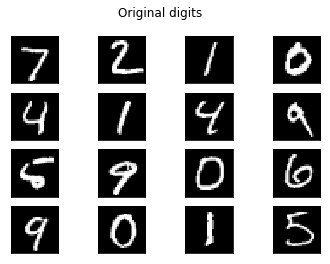

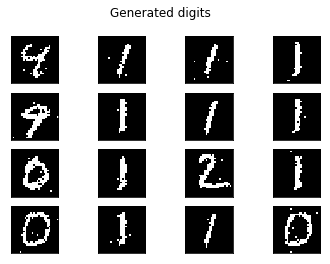

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("./mnist/data/", one_hot=False)

#RBM Network (784 visible nodes, 200 hidden nodes)
#16개의 손글씨 이미지를 준비
#CD알고리즘을 적용하기 위해 v1, h1 변수도 준비
num_sample = 16
v0=mnist.test.images[:num_sample,:]
label = mnist.test.labels[:num_sample]
N, v_dim = v0.shape
h_dim = 200 #숨은 변수의 개수를 조절하면 생성되는 이미지의 다양성과 해상도가 바뀐다!
h0 = np.zeros((N, h_dim))
v1 = np.zeros((N, v_dim))
h1 = np.zeros((N, h_dim))


#CD알고리즘의 학습률과 반복횟수 설정 및 RBM네트워크의 파라미터 값의 초기화
alpha = 0.05
num_iter = 500
a = 0.5-np.random.rand(v_dim)
b = 0.5-np.random.rand(h_dim)
w = 0.5-np.random.rand(v_dim, h_dim)

#CD알고리즘을 통한 학습
for k in range(num_iter):
    for n in range(N):
        for j in range(h_dim):
            de = np.inner(v0[n], w[:,j]) + b[j] #h0[j]=1와 h0[j]=0인 경우 RBM의 에너지 차이
            if(1./(1.+np.exp(-de)) > np.random.rand()):
                h0[n][j] = 1.
            else:
                h0[n][j] = 0.
            
        for i in range(v_dim):
            de = np.inner(h0[n], w[i, :]) + a[i] #v1[i]=1와 v1[i]=0인 경우 RBM의 에너지 차이
            if(1./(1.+np.exp(-de)) > np.random.rand()):
                v1[n][i] = 1.
            else:
                v1[n][i] = 0.
                        
        for j in range(h_dim):
            de = np.inner(v1[n], w[:,j]) + b[j] #h1[j]=1와 h1[j]=0인 경우 RBM의 에너지 차이
            if(1./(1.+np.exp(-de)) > np.random.rand()):
                h1[n][j] = 1.
            else:
                h1[n][j] = 0.

    #D_KL의 기울기 계산                
    da = np.mean(v0 - v1, axis = 0) #-dD_KL/da[i] = 1/N\sum_n v0[n][i] - v1[n][i]
    db = np.mean(h0 - h1, axis = 0) #-dD_KL/db[j] = 1/N \sum_n h0[n][j] - h1[n][j]
    dw = (np.matmul(v0.T, h0) - np.matmul(v1.T, h1))/N #-dD_KL/dw[i][j] = 1/N \sum_n v0[n][i]*h0[n][j] - v1[n][i]*h1[n][j]

    #RBM 파라미터들의 업데이트    
    a += alpha*da
    b += alpha*db
    w += alpha*dw

    
    
#학습된 RBM에서 손글씨 이미지를 생성
num_equilibrium = 200 #숨은 변수값을 평형상태의 RBM네트워크에 맞추기 위한 평형화 과정에 필요한 반복횟수
v_sample = np.zeros((num_sample, v_dim)) #생성한 이미지 샘플을 저장하기 위한 변수

for n in range(num_sample):
    h_gen = np.round(np.random.rand(h_dim)) #무작위로 숨은 변수를 선택
    v_gen = np.zeros(v_dim)
    for k in range(num_equilibrium): #visible layer와 hidden layer를 반복해서 오가면서 손글씨 이미지를 샘플링하는 과정 
        for i in range(v_dim):
            de = np.inner(h_gen, w[i, :]) + a[i]
            if(1./(1.+np.exp(-de)) > np.random.rand()):
                v_gen[i] = 1.
            else:
                v_gen[i] = 0.
                
        for j in range(h_dim):
            de = np.inner(v_gen, w[:,j]) + b[j]
            if(1./(1.+np.exp(-de)) > np.random.rand()):
                h_gen[j] = 1.
            else:
                h_gen[j] = 0. 
    v_sample[n] = v_gen
    
    
#학습하는 원래 손글씨 이미지와 RBM이 생성한 손글씨 이미지를 시각화    
fig1=plt.figure()
fig1.suptitle('Original digits')
for n in range(num_sample):
    subplot=fig1.add_subplot(4,4,n+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(v0[n].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

fig2=plt.figure()
fig2.suptitle('Generated digits')
for n in range(num_sample):
    subplot=fig2.add_subplot(4,4,n+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(v_sample[n].reshape((28,28)), cmap=plt.cm.gray)
plt.show()
